In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score , confusion_matrix
from torchvision.models import VGG16_Weights
import seaborn as sns

# Upload & Read Data

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
MSS_train = '/content/drive/MyDrive/MSS_train'
MSI_train = '/content/drive/MyDrive/MSI_train'

In [ ]:
print(f'Number of Microsatellite Stability images - train folder: {len(os.listdir(MSS_train))}')
print(f'Number of Microsatellite Instability - train folder: {len(os.listdir(MSI_train))}')

Number of Microsatellite Stability images - train folder: 596
Number of Microsatellite Instability - train folder: 603


In [ ]:
MSS_test = '/content/drive/MyDrive/MSS_test'
MSI_test = '/content/drive/MyDrive/MSI_test'

In [ ]:
print(f'Number of Microsatellite Stability images - test folder: {len(os.listdir(MSS_test))}')
print(f'Number of Microsatellite Instability images - test folder: {len(os.listdir(MSI_test))}')

Number of Microsatellite Stability images - test folder: 403
Number of Microsatellite Instability images - test folder: 463


In [ ]:
MSS_val = '/content/drive/MyDrive/MSS_val'
MSI_val = '/content/drive/MyDrive/MSI_val'

In [ ]:
print(f'Number of Microsatellite Stability images - val folder: {len(os.listdir(MSS_val))}')
print(f'Number of Microsatellite Instability images - val folder: {len(os.listdir(MSI_val))}')

Number of Microsatellite Stability images - val folder: 210
Number of Microsatellite Instability images - val folder: 205


**Defining Data augmentation and normalization for training using transforms**

> Resize image to (224, 244)

> Normalize the image demistion to (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
data_transforms = transforms.Compose([
    #resizes the input image to the specified size of (224, 224) pixels.
    transforms.Resize((224, 224)),
    #Convert Image to Pytorch tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Load the datasets with ImageFolder**

In [ ]:
# ImageFolder: PyTorch utility for loading image data
train_data = ImageFolder(root='/content/drive/MyDrive/train_GC', transform=data_transforms)
test_data = ImageFolder(root='/content/drive/MyDrive/test_GC', transform=data_transforms)
val_data = ImageFolder(root='/content/drive/MyDrive/val_GC', transform=data_transforms)

# **Create a classifier using pre-trained model from pytorch - GoogLeNet**


# **On Val Test**

First combination lr= 0.003  wd=0.001 momentom=0.5 batch size= 64

In [ ]:
#data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier for  classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.6942, Train Accuracy: 0.5238
Epoch 1/9, Loss: 0.6701, Train Accuracy: 0.5980
Epoch 2/9, Loss: 0.6566, Train Accuracy: 0.6222
Epoch 3/9, Loss: 0.6418, Train Accuracy: 0.6514
Epoch 4/9, Loss: 0.6182, Train Accuracy: 0.6806
Epoch 5/9, Loss: 0.6024, Train Accuracy: 0.6989
Epoch 6/9, Loss: 0.5818, Train Accuracy: 0.7281
Epoch 7/9, Loss: 0.5676, Train Accuracy: 0.7356
Epoch 8/9, Loss: 0.5414, Train Accuracy: 0.7573
Epoch 9/9, Loss: 0.5220, Train Accuracy: 0.7723
Final Training Accuracy: 0.7723


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6410


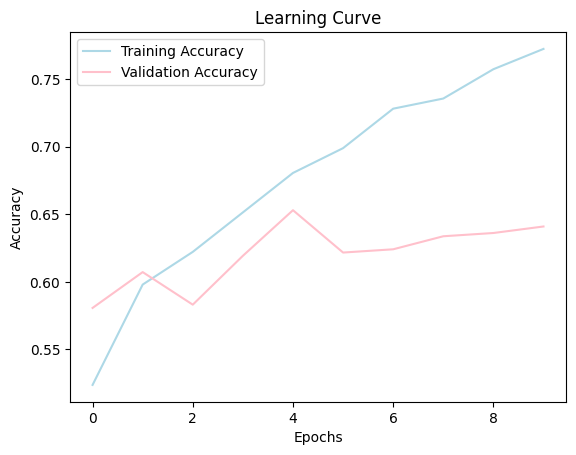

Training Accuracy: 0.7723
Validation Accuracy: 0.6410


In [ ]:
#learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Second combination lr= 0.001 wd=0.005 momentom=0.7 batch size= 32

In [ ]:
#data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

#  GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier for  classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.6893, Train Accuracy: 0.5505
Epoch 1/9, Loss: 0.6699, Train Accuracy: 0.5972
Epoch 2/9, Loss: 0.6561, Train Accuracy: 0.6022
Epoch 3/9, Loss: 0.6351, Train Accuracy: 0.6455
Epoch 4/9, Loss: 0.6230, Train Accuracy: 0.6831
Epoch 5/9, Loss: 0.6036, Train Accuracy: 0.6972
Epoch 6/9, Loss: 0.5908, Train Accuracy: 0.7014
Epoch 7/9, Loss: 0.5677, Train Accuracy: 0.7264
Epoch 8/9, Loss: 0.5533, Train Accuracy: 0.7498
Epoch 9/9, Loss: 0.5310, Train Accuracy: 0.7781
Training Accuracy: 0.7781


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6675


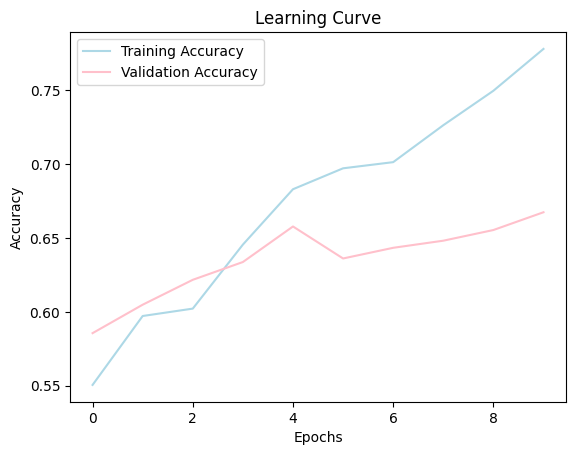

Training Accuracy: 0.7781
Validation Accuracy: 0.6675


In [ ]:
#learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Third combination lr= 0.001 wd=0.01 momentom=0.7 batch size= 64

In [ ]:
#data loaders with batch size 16
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7020, Train Accuracy: 0.5013
Epoch 1/9, Loss: 0.6905, Train Accuracy: 0.5263
Epoch 2/9, Loss: 0.6809, Train Accuracy: 0.5588
Epoch 3/9, Loss: 0.6656, Train Accuracy: 0.5972
Epoch 4/9, Loss: 0.6483, Train Accuracy: 0.6405
Epoch 5/9, Loss: 0.6408, Train Accuracy: 0.6505
Epoch 6/9, Loss: 0.6299, Train Accuracy: 0.6847
Epoch 7/9, Loss: 0.6282, Train Accuracy: 0.6797
Epoch 8/9, Loss: 0.6068, Train Accuracy: 0.7139
Epoch 9/9, Loss: 0.5996, Train Accuracy: 0.7106
Training Accuracy: 0.7106


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6651


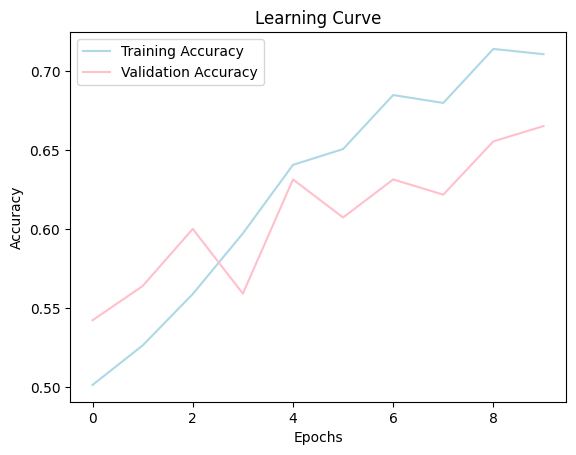

Training Accuracy: 0.7106
Validation Accuracy: 0.6651


In [ ]:
#learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Fourth combination lr= 0.003 wd=0.001 momentom=0.5 batch size= 128

In [ ]:
#  data loaders with batch size 128
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Use GPU if available
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7004, Train Accuracy: 0.5179
Epoch 1/9, Loss: 0.6991, Train Accuracy: 0.5221
Epoch 2/9, Loss: 0.6716, Train Accuracy: 0.6047
Epoch 3/9, Loss: 0.6646, Train Accuracy: 0.5755
Epoch 4/9, Loss: 0.6528, Train Accuracy: 0.6080
Epoch 5/9, Loss: 0.6438, Train Accuracy: 0.6539
Epoch 6/9, Loss: 0.6345, Train Accuracy: 0.6564
Epoch 7/9, Loss: 0.6260, Train Accuracy: 0.6714
Epoch 8/9, Loss: 0.6176, Train Accuracy: 0.6964
Epoch 9/9, Loss: 0.6091, Train Accuracy: 0.7023
Final Training Accuracy: 0.7023


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6482


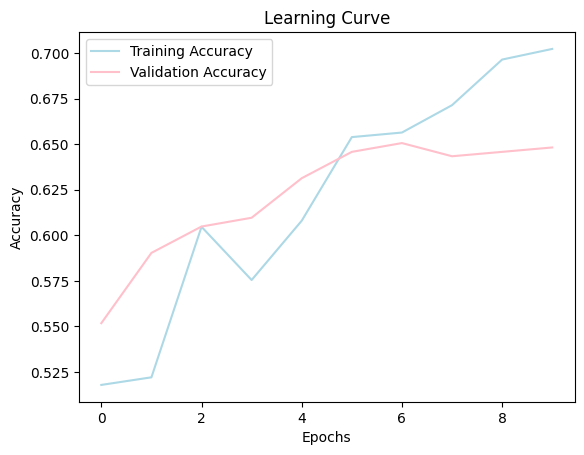

Training Accuracy: 0.7023
Validation Accuracy: 0.6482


In [ ]:
# learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

# **On Test Set**

In [ ]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [ ]:
#data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# the GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  model parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
test_accuracies = []

# Start training time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    correct_test= 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test/ total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

# Calculate  training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/your_trained_model.pth')

# final training accuracy
print(f'Training Accuracy: {train_accuracies[-1]:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 98.5MB/s]


Number of parameters in the model: 5601954
Epoch 0/9, Loss: 0.6986, Train Accuracy: 0.5104
Epoch 1/9, Loss: 0.6821, Train Accuracy: 0.5671
Epoch 2/9, Loss: 0.6542, Train Accuracy: 0.6314
Epoch 3/9, Loss: 0.6399, Train Accuracy: 0.6514
Epoch 4/9, Loss: 0.6256, Train Accuracy: 0.6739
Epoch 5/9, Loss: 0.6057, Train Accuracy: 0.6889
Epoch 6/9, Loss: 0.5824, Train Accuracy: 0.7164
Epoch 7/9, Loss: 0.5705, Train Accuracy: 0.7248
Epoch 8/9, Loss: 0.5480, Train Accuracy: 0.7406
Epoch 9/9, Loss: 0.5337, Train Accuracy: 0.7498
Total training time: 798.23 seconds
Training Accuracy: 0.7498
Confusion Matrix:
[[289 174]
 [146 257]]


In [ ]:
# Calculate  overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on Test Set: {overall_accuracy:.4f}')

# Calculate  classification report
class_report = classification_report(all_labels, all_preds)
print(f'Classification Report:\n{class_report}')

Overall Accuracy on Test Set: 0.6305
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       463
           1       0.60      0.64      0.62       403

    accuracy                           0.63       866
   macro avg       0.63      0.63      0.63       866
weighted avg       0.63      0.63      0.63       866



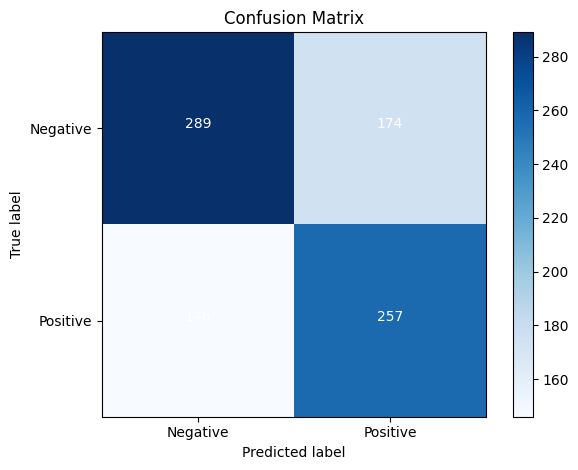

In [ ]:
# confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

#labels
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

#text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


# **Interface**

Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQSNLFLWKRDR-TCGA-CM-4743-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQLWTDNCDGIM-TCGA-CM-6171-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQIGPHSNLCHK-TCGA-QG-A5Z2-01Z-00-DX2.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQTISQRRTKGR-TCGA-G4-6304-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQMWRCKLLDEK-TCGA-NH-A5IV-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQVCIQDISFQG-TCGA-D5-6530-01Z-00-DX1.jpg, Predicted Class: MSI
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-APGGPNEMRKYR-TCGA-AA-3968-01Z-00-DX1.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-APGHEMNKGGLK-TCGA-A6-61

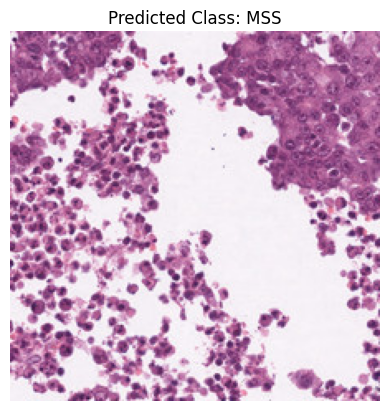

Predicted class: MSS


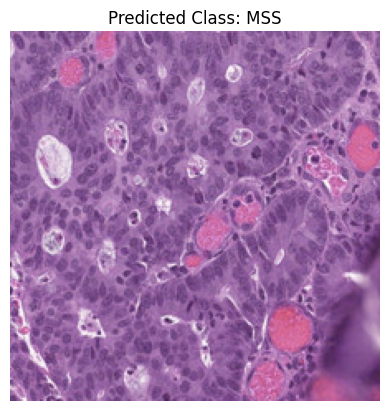

Predicted class: MSI


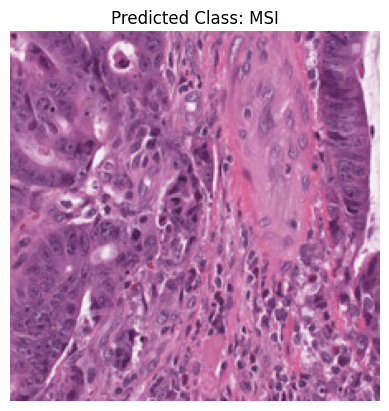

Predicted class: MSS


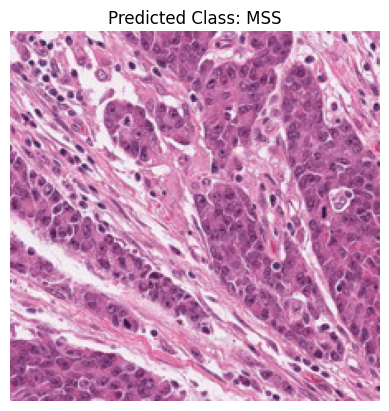

Predicted class: MSS


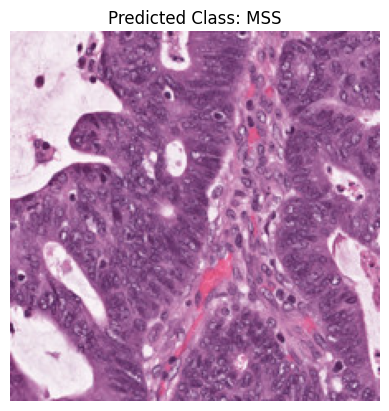

Predicted class: MSI


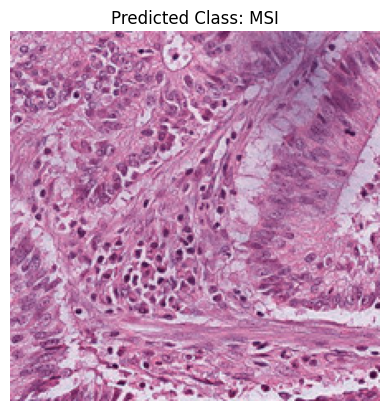

Predicted class: MSI


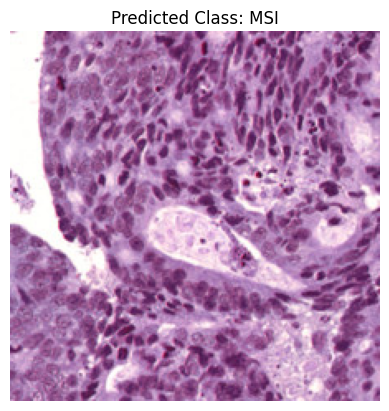

Predicted class: MSS


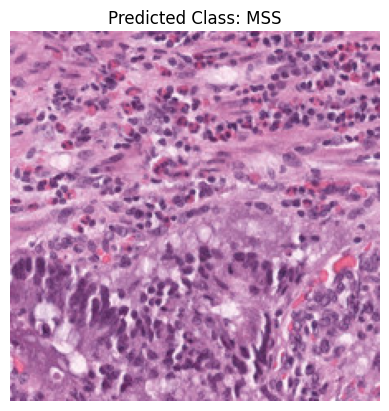

Predicted class: MSI


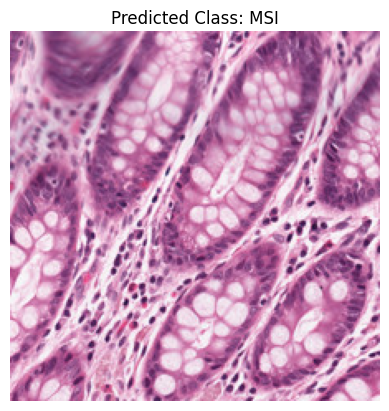

Predicted class: MSI


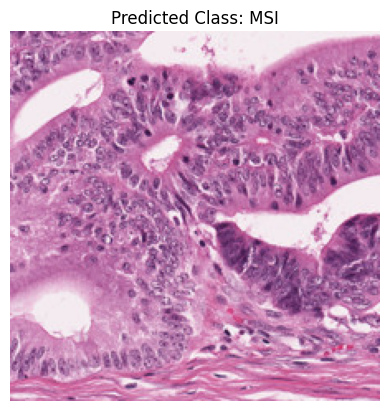

Predicted class: MSI


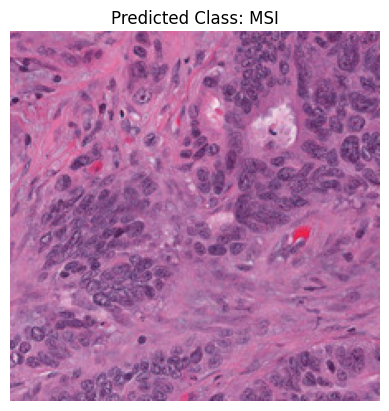

Predicted class: MSI


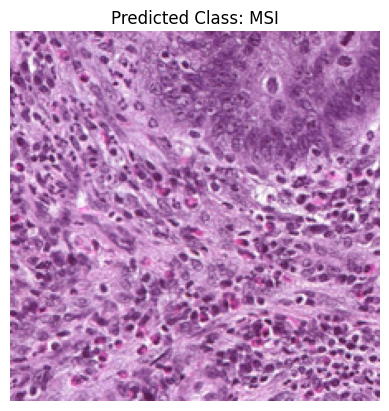

In [ ]:
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GoogLeNet model
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Modify the classifier forclassification
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load('/content/drive/MyDrive/your_trained_model.pth'))
model.eval()

classes = ['MSS', 'MSI']

def predict_image(file_path):
    # Print file path
    #print("Processing image:", file_path)

    img = Image.open(file_path)
    img = input_transform(img)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]

    print("Predicted class:", predicted_class)

    return predicted_class

# Directory containing images to classify
image_dir = '/content/drive/MyDrive/load images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

for image_file in image_files:
    prediction = predict_image(image_file)
    print(f"Image: {image_file}, Predicted Class: {prediction}")


import matplotlib.pyplot as plt

def show_prediction(file_path, predicted_class):
    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

for image_file in image_files:
    prediction = predict_image(image_file)
    show_prediction(image_file, prediction)